In [ ]:
!pip install transformers
!pip install torch
!pip install --upgrade datasets
!pip install tqdm
!pip install rouge

from sklearn.metrics.pairwise import cosine_similarity
from datasets import Dataset, DatasetDict, load_dataset
from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoTokenizer, BertTokenizer, BertModel, AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import cohen_kappa_score
from rouge import Rouge
from scipy.stats import pearsonr, spearmanr

import json
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
import random
import torch
import re
import transformers
import seaborn as sns

base = "alqa"

CALCULATION

In [ ]:
dataset_gemma = load_dataset("Ramitha/" + base + "-results-40-gemma-self")
df_gemma = pd.DataFrame(dataset_gemma['rawcases'])
dataset_llama = load_dataset("Ramitha/" + base + "-results-40-llama-self")
df_llama = pd.DataFrame(dataset_llama['rawcases'])
dataset_falcon = load_dataset("Ramitha/" + base + "-results-40-falcon-self")
df_falcon = pd.DataFrame(dataset_falcon['rawcases'])
dataset_mistral = load_dataset("Ramitha/" + base + "-results-40-mistral-self")
df_mistral = pd.DataFrame(dataset_mistral['rawcases'])

if base == "alqa" or base == "sl":
    df_gemma = df_gemma[0:400]
    df_llama = df_llama[760:1160]
    df_falcon = df_falcon[40:440]
    df_mistral = df_mistral[760:1160]

df_list = [df_llama, df_falcon, df_gemma, df_mistral]

In [3]:
def get_case_alignment(case_embs, case_base, prob_weight, solution_weight, weighting_type='normalized'):
    emb1, emb2 = case_embs
    emb1 = emb1.reshape(1, -1) if emb1.ndim == 1 else emb1
    emb2 = emb2.reshape(1, -1) if emb2.ndim == 1 else emb2

    alignment_scores = []
    weights = []

    for past_case in case_base:
        past_prob_emb, past_solution_emb = past_case
        past_prob_emb = past_prob_emb.reshape(1, -1) if past_prob_emb.ndim == 1 else past_prob_emb
        past_solution_emb = past_solution_emb.reshape(1, -1) if past_solution_emb.ndim == 1 else past_solution_emb

        prob_similarity = cosine_similarity(emb1, past_prob_emb)[0][0]  # ∈ [0,1]
        solution_similarity = cosine_similarity(emb2, past_solution_emb)[0][0]  # ∈ [0,1]

        alignment_score = (
            prob_weight * prob_similarity + solution_weight * solution_similarity
        ) / (prob_weight + solution_weight)

        alignment_scores.append(alignment_score)
        weights.append(prob_similarity)

    alignment_scores = np.array(alignment_scores)
    weights = np.array(weights)

    if len(weights) == 0 or np.sum(weights) == 0:
        return 0.0

    if weighting_type == 'raw':
        weights = weights / np.sum(weights)
        weighted_alignment_score = np.sum(alignment_scores)

    elif weighting_type == 'normalized':
        weights = weights / np.sum(weights)
        weighted_alignment_score = np.sum(alignment_scores * weights)

    elif weighting_type == 'softmax':
        exp_weights = np.exp(weights)
        softmax_weights = exp_weights / np.sum(exp_weights)
        weighted_alignment_score = np.sum(alignment_scores * softmax_weights)

    elif weighting_type == 'exponential_decay':
        decay_constant = 0.5
        sorted_indices = np.argsort(-weights)
        decay_weights = np.exp(-decay_constant * np.arange(len(weights)))
        decay_weights = decay_weights[np.argsort(sorted_indices)]  # unsort
        decay_weights = decay_weights / np.sum(decay_weights)
        weighted_alignment_score = np.sum(alignment_scores * decay_weights)

    elif weighting_type == 'inverse_distance':
        epsilon = 1e-6
        inv_weights = 1 / (1 - weights + epsilon)
        normalized_inv_weights = inv_weights / np.sum(inv_weights)
        weighted_alignment_score = np.sum(alignment_scores * normalized_inv_weights)

    else:
        raise ValueError(f"Unsupported weighting_type: {weighting_type}")

    return float(weighted_alignment_score)

In [7]:
columns_to_keep = [
    "temperature", "model", "gold_standard_cos", "answer_judge_cos_mean",
    "ILRSim", "ILRError",

    "p:1_s:9_raw", "p:2_s:8_raw", "p:3_s:7_raw", "p:4_s:6_raw", "p:5_s:5_raw",
    "p:6_s:4_raw", "p:7_s:3_raw", "p:8_s:2_raw", "p:9_s:1_raw",

    "p:1_s:9_normalized", "p:2_s:8_normalized", "p:3_s:7_normalized", "p:4_s:6_normalized", "p:5_s:5_normalized",
    "p:6_s:4_normalized", "p:7_s:3_normalized", "p:8_s:2_normalized", "p:9_s:1_normalized",

    "p:1_s:9_softmax", "p:2_s:8_softmax", "p:3_s:7_softmax", "p:4_s:6_softmax", "p:5_s:5_softmax",
    "p:6_s:4_softmax", "p:7_s:3_softmax", "p:8_s:2_softmax", "p:9_s:1_softmax",

    "p:1_s:9_exponential_decay", "p:2_s:8_exponential_decay", "p:3_s:7_exponential_decay", "p:4_s:6_exponential_decay", "p:5_s:5_exponential_decay",
    "p:6_s:4_exponential_decay", "p:7_s:3_exponential_decay", "p:8_s:2_exponential_decay", "p:9_s:1_exponential_decay",

    "p:1_s:9_inverse_distance", "p:2_s:8_inverse_distance", "p:3_s:7_inverse_distance", "p:4_s:6_inverse_distance", "p:5_s:5_inverse_distance",
    "p:6_s:4_inverse_distance", "p:7_s:3_inverse_distance", "p:8_s:2_inverse_distance", "p:9_s:1_inverse_distance",
    ]

selected_data = []

for i, df in enumerate(df_list):
    embedding_columns = [
        'question_emb', 'answerGenerated_emb', 'question_answerGenerated_falcon_emb',
        'reverse_answer_answerGenerated_falcon_emb', 'question_answerGenerated_gemma_emb',
        'reverse_answer_answerGenerated_gemma_emb', 'question_answerGenerated_mistral_emb',
        'reverse_answer_answerGenerated_mistral_emb', 'question_answerGenerated_llama_emb',
        'reverse_answer_answerGenerated_llama_emb'
    ]

    for col in embedding_columns:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Rows"):
        case_base = []

        if i == 0:
            case_base = [
                [row['question_answerGenerated_falcon_emb'], row['reverse_answer_answerGenerated_falcon_emb']],
                [row['question_answerGenerated_gemma_emb'], row['reverse_answer_answerGenerated_gemma_emb']],
                [row['question_answerGenerated_mistral_emb'], row['reverse_answer_answerGenerated_mistral_emb']]
            ]
        elif i == 1:
            case_base = [
                [row['question_answerGenerated_llama_emb'], row['reverse_answer_answerGenerated_llama_emb']],
                [row['question_answerGenerated_gemma_emb'], row['reverse_answer_answerGenerated_gemma_emb']],
                [row['question_answerGenerated_mistral_emb'], row['reverse_answer_answerGenerated_mistral_emb']]
            ]
        elif i == 2:
            case_base = [
                [row['question_answerGenerated_falcon_emb'], row['reverse_answer_answerGenerated_falcon_emb']],
                [row['question_answerGenerated_llama_emb'], row['reverse_answer_answerGenerated_llama_emb']],
                [row['question_answerGenerated_mistral_emb'], row['reverse_answer_answerGenerated_mistral_emb']]
            ]
        elif i == 3:
            case_base = [
                [row['question_answerGenerated_falcon_emb'], row['reverse_answer_answerGenerated_falcon_emb']],
                [row['question_answerGenerated_gemma_emb'], row['reverse_answer_answerGenerated_gemma_emb']],
                [row['question_answerGenerated_llama_emb'], row['reverse_answer_answerGenerated_llama_emb']]
            ]

        df.at[index, 'p:1_s:9_raw'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.1, 0.9, 'raw')
        df.at[index, 'p:1_s:9_normalized'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.1, 0.9, 'normalized')
        df.at[index, 'p:1_s:9_softmax'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.1, 0.9, 'softmax')
        df.at[index, 'p:1_s:9_exponential_decay'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.1, 0.9, 'exponential_decay')
        df.at[index, 'p:1_s:9_inverse_distance'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.1, 0.9, 'inverse_distance')

        df.at[index, 'p:2_s:8_raw'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.2, 0.8, 'raw')
        df.at[index, 'p:2_s:8_normalized'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.2, 0.8, 'normalized')
        df.at[index, 'p:2_s:8_softmax'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.2, 0.8, 'softmax')
        df.at[index, 'p:2_s:8_exponential_decay'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.2, 0.8, 'exponential_decay')
        df.at[index, 'p:2_s:8_inverse_distance'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.2, 0.8, 'inverse_distance')

        df.at[index, 'p:3_s:7_raw'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.3, 0.7, 'raw')
        df.at[index, 'p:3_s:7_normalized'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.3, 0.7, 'normalized')
        df.at[index, 'p:3_s:7_softmax'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.3, 0.7, 'softmax')
        df.at[index, 'p:3_s:7_exponential_decay'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.3, 0.7, 'exponential_decay')
        df.at[index, 'p:3_s:7_inverse_distance'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.3, 0.7, 'inverse_distance')

        df.at[index, 'p:4_s:6_raw'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.4, 0.6, 'raw')
        df.at[index, 'p:4_s:6_normalized'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.4, 0.6, 'normalized')
        df.at[index, 'p:4_s:6_softmax'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.4, 0.6, 'softmax')
        df.at[index, 'p:4_s:6_exponential_decay'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.4, 0.6, 'exponential_decay')
        df.at[index, 'p:4_s:6_inverse_distance'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.4, 0.6, 'inverse_distance')

        df.at[index, 'p:5_s:5_raw'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.5, 0.5, 'raw')
        df.at[index, 'p:5_s:5_normalized'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.5, 0.5, 'normalized')
        df.at[index, 'p:5_s:5_softmax'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.5, 0.5, 'softmax')
        df.at[index, 'p:5_s:5_exponential_decay'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.5, 0.5, 'exponential_decay')
        df.at[index, 'p:5_s:5_inverse_distance'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.5, 0.5, 'inverse_distance')

        df.at[index, 'p:6_s:4_raw'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.6, 0.4, 'raw')
        df.at[index, 'p:6_s:4_normalized'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.6, 0.4, 'normalized')
        df.at[index, 'p:6_s:4_softmax'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.6, 0.4, 'softmax')
        df.at[index, 'p:6_s:4_exponential_decay'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.6, 0.4, 'exponential_decay')
        df.at[index, 'p:6_s:4_inverse_distance'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.6, 0.4, 'inverse_distance')

        df.at[index, 'p:7_s:3_raw'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.7, 0.3, 'raw')
        df.at[index, 'p:7_s:3_normalized'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.7, 0.3, 'normalized')
        df.at[index, 'p:7_s:3_softmax'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.7, 0.3, 'softmax')
        df.at[index, 'p:7_s:3_exponential_decay'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.7, 0.3, 'exponential_decay')
        df.at[index, 'p:7_s:3_inverse_distance'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.7, 0.3, 'inverse_distance')

        df.at[index, 'p:8_s:2_raw'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.8, 0.2, 'raw')
        df.at[index, 'p:8_s:2_normalized'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.8, 0.2, 'normalized')
        df.at[index, 'p:8_s:2_softmax'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.8, 0.2, 'softmax')
        df.at[index, 'p:8_s:2_exponential_decay'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.8, 0.2, 'exponential_decay')
        df.at[index, 'p:8_s:2_inverse_distance'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.8, 0.2, 'inverse_distance')

        df.at[index, 'p:9_s:1_raw'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.9, 0.1, 'raw')
        df.at[index, 'p:9_s:1_normalized'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.9, 0.1, 'normalized')
        df.at[index, 'p:9_s:1_softmax'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.9, 0.1, 'softmax')
        df.at[index, 'p:9_s:1_exponential_decay'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.9, 0.1, 'exponential_decay')
        df.at[index, 'p:9_s:1_inverse_distance'] = get_case_alignment([row['question_emb'], row['answerGenerated_emb']], case_base, 0.9, 0.1, 'inverse_distance')

    selected_data.append(df[columns_to_keep])
final_df = pd.concat(selected_data, ignore_index=True)

Processing Rows: 100%|██████████| 400/400 [00:52<00:00,  7.58it/s]


In [ ]:
final_df.columns

ANALYSIS

In [8]:
df_llama = final_df[final_df['model'] == 'llama'].copy()
df_gemma = final_df[final_df['model'] == 'gemma'].copy()
df_falcon = final_df[final_df['model'] == 'falcon'].copy()
df_mistral = final_df[final_df['model'] == 'mistral'].copy()

Pearson's correlation

In [9]:
weights = [f"p:{i}_s:{10-i}" for i in range(1, 10)]
methods = ["raw", "normalized", "softmax", "exponential_decay", "inverse_distance"]

model_dfs = {
    "LLaMA": df_llama,
    "Gemma": df_gemma,
    "Falcon": df_falcon,
    "Mistral": df_mistral
}

avg_heatmap_data = pd.DataFrame(index=methods, columns=weights, dtype=float)
for model_name, df in model_dfs.items():
    heatmap_data = pd.DataFrame(index=methods, columns=weights)
    for method in methods:
        for w in weights:
            col_name = f"{w}_{method}"
            if col_name in df.columns:
                valid_idx = df[[col_name, 'gold_standard_cos']].dropna().index
                if len(valid_idx) > 1:
                    corr, _ = pearsonr(df.loc[valid_idx, col_name], df.loc[valid_idx, 'gold_standard_cos'])
                    heatmap_data.loc[method, w] = corr
    heatmap_data = heatmap_data.astype(float)
    avg_heatmap_data = avg_heatmap_data.add(heatmap_data, fill_value=0)

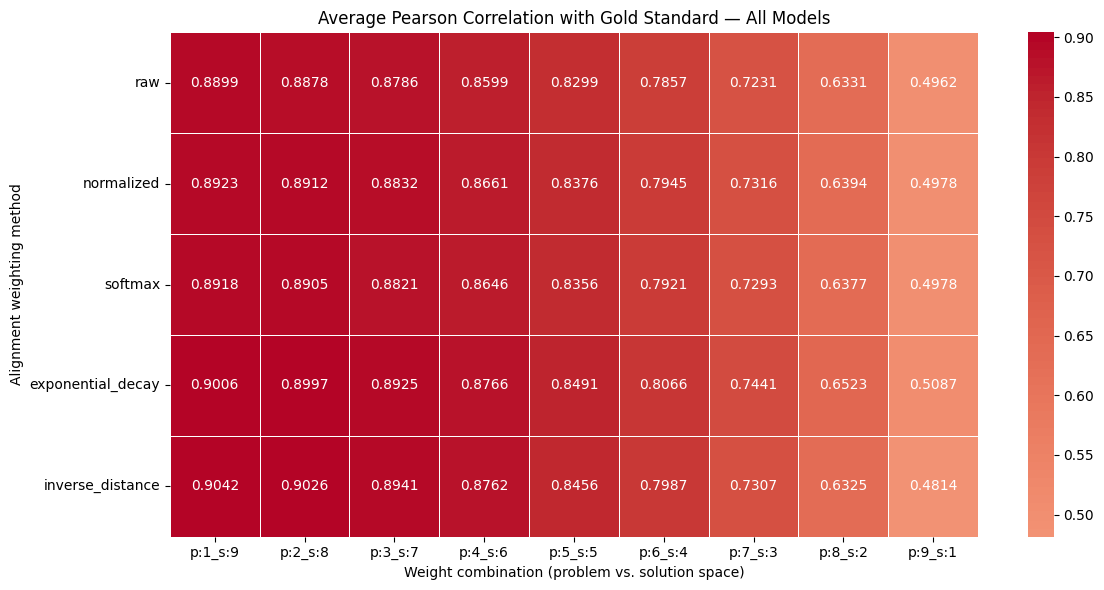

In [10]:
avg_heatmap_data /= len(model_dfs)

plt.figure(figsize=(12, 6))
sns.heatmap(avg_heatmap_data, annot=True, fmt=".4f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Average Pearson Correlation with Gold Standard — All Models")
plt.xlabel("Weight combination (problem vs. solution space)")
plt.ylabel("Alignment weighting method")
plt.tight_layout()
plt.show()